In [1]:
# imports
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score

In [2]:
# load data
all_data = loadmat('data/sample_1.mat')
sample_data = np.array(all_data['data'])
# extract spike times for later comparison
spike_times = np.array(all_data['spike_times'])

In [3]:
# parameters
seconds = 120
sr = 24000 # sample rate = 24kHz

data = sample_data[0][:round(seconds*sr)]
ground_truth_spikes = spike_times[0][0][0][:round(seconds*sr)]

mean_data = np.mean(data)
std_data = np.std(data)

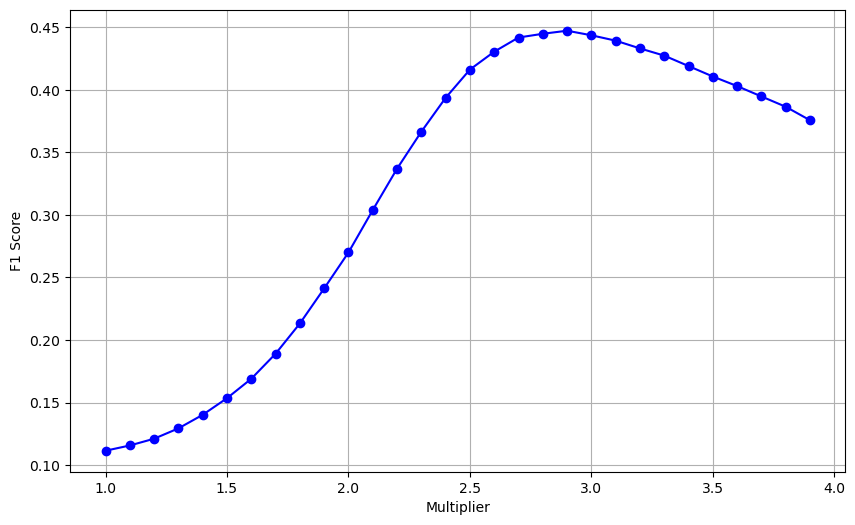

Best multiplier: 2.9000000000000017, F1 score: 0.4471521778723739


In [4]:
def detect_spikes(data, multiplier):
    spike_times_start_only = []
    spike_times_reconstructed = np.where(data >= np.mean(data) + multiplier * np.std(data))[0]
    
    if len(spike_times_reconstructed) > 0:
        spike_times_start_only.append(spike_times_reconstructed[0])
        spike_times_start_only.extend(spike_times_reconstructed[np.where(np.diff(spike_times_reconstructed) > 10)[0]+1])

    return np.array(spike_times_start_only)


def calculate_f1_score(detected_spikes, ground_truth_spikes, sr, tolerance=0.001):
    # convert tolerance (time duration in seconds: 0.001 = 1ms) to number of samples
    tolerance_in_samples = tolerance * sr
    detected_binary = np.zeros_like(data)

    # set values to 1 where spikes occur (detected_binary[start_index:end_index] = 1)
    for spike in (detected_spikes / sr):
        detected_binary[int(spike * sr - tolerance_in_samples): int(spike * sr + tolerance_in_samples)] = 1

    ground_truth_binary = np.zeros_like(data)
    for spike in (ground_truth_spikes / sr):
        ground_truth_binary[int(spike * sr - tolerance_in_samples): int(spike * sr + tolerance_in_samples)] = 1

    # calculate F1 score
    f1 = f1_score(ground_truth_binary, detected_binary)
    
    return f1

# test different multiplier values for threshold
multipliers = np.arange(1.0, 4.0, 0.1) 
f1_scores = []

for multiplier in multipliers:
    detected_spikes = detect_spikes(data, multiplier)
    f1 = calculate_f1_score(detected_spikes, spike_times[0][0][0][:round(seconds*sr)], sr)
    f1_scores.append(f1)

# plot F1 scores as a function of the multiplier
plt.figure(figsize=(10, 6))
plt.plot(multipliers, f1_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Multiplier')
plt.ylabel('F1 Score')
plt.grid()
plt.show()

# get best multiplier based on F1 score
best_f1 = max(f1_scores)
best_multiplier = multipliers[np.argmax(f1_scores)]
print(f"Best multiplier: {best_multiplier}, F1 score: {best_f1}")

In [5]:
# apply threshold to raw data
spike_times_reconstructed = np.where(data >= mean_data + best_multiplier * std_data)[0]
spike_times_start_only = []
spike_times_start_only.append(spike_times_reconstructed[0])
# if data is above threshold back to back, count all occurences as one single spike
spike_times_start_only.extend(spike_times_reconstructed[np.where(np.diff(spike_times_reconstructed) > 10)[0]+1])

In [6]:
# only runs this cell if seconds parameter is below 5, otherwise the plot gets too convoluted
if seconds < 5:
    # display data
    plt.figure(figsize=(25,6))
    plt.plot(np.linspace(0, seconds, round(seconds*sr)), data)
    plt.xlim(0, seconds)

    # plot where we think a spike is 
    for i, spike in enumerate(spike_times_start_only):
        # plt.axvline(spike/sr - .0008, c='red', alpha=0.5)
        plt.axvspan(spike/sr - .0008, spike/sr + .001, facecolor='r', alpha=0.2)
        plt.text(spike/sr - 0.006, 110 if i%2 == 0 else 100, i+1, c='r')

    # plot ground truth for reference
    for i, spike in enumerate(ground_truth_spikes / sr):
        if round(spike*24000) > round(seconds*24000): break
        plt.axvline(spike, c='k', alpha=1)
        plt.text(spike - 0.006, 85 if i%2 == 0 else 75, i+1, c='b')
        
    plt.show()

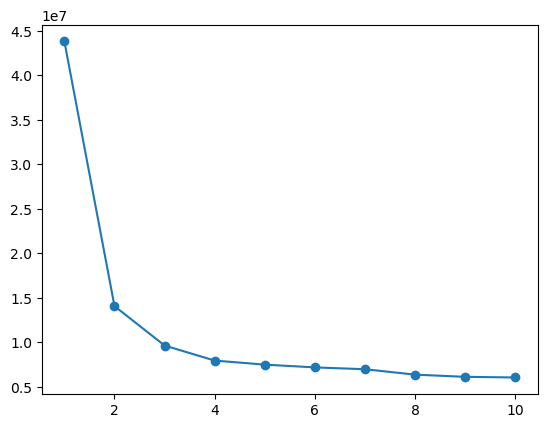

In [8]:
number_of_spikes = len(spike_times_start_only)

# get max & min voltage of all spikes (for plotting purposes)
ymax = 0
ymin = 0
spikes = []
for spike in spike_times_start_only:
    start = round(spike - .0008 * sr)
    end = round(spike + .001 * sr)
    if np.max(data[start:end]) > ymax: ymax = np.max(data[start:end])
    if np.min(data[start:end]) < ymin: ymin = np.min(data[start:end])
    # store detected spikes in list
    spikes.append(data[start:end])

inertias = []
# determine best number of clusters via elbow plot
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init='auto')
    kmeans.fit(spikes)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.show()


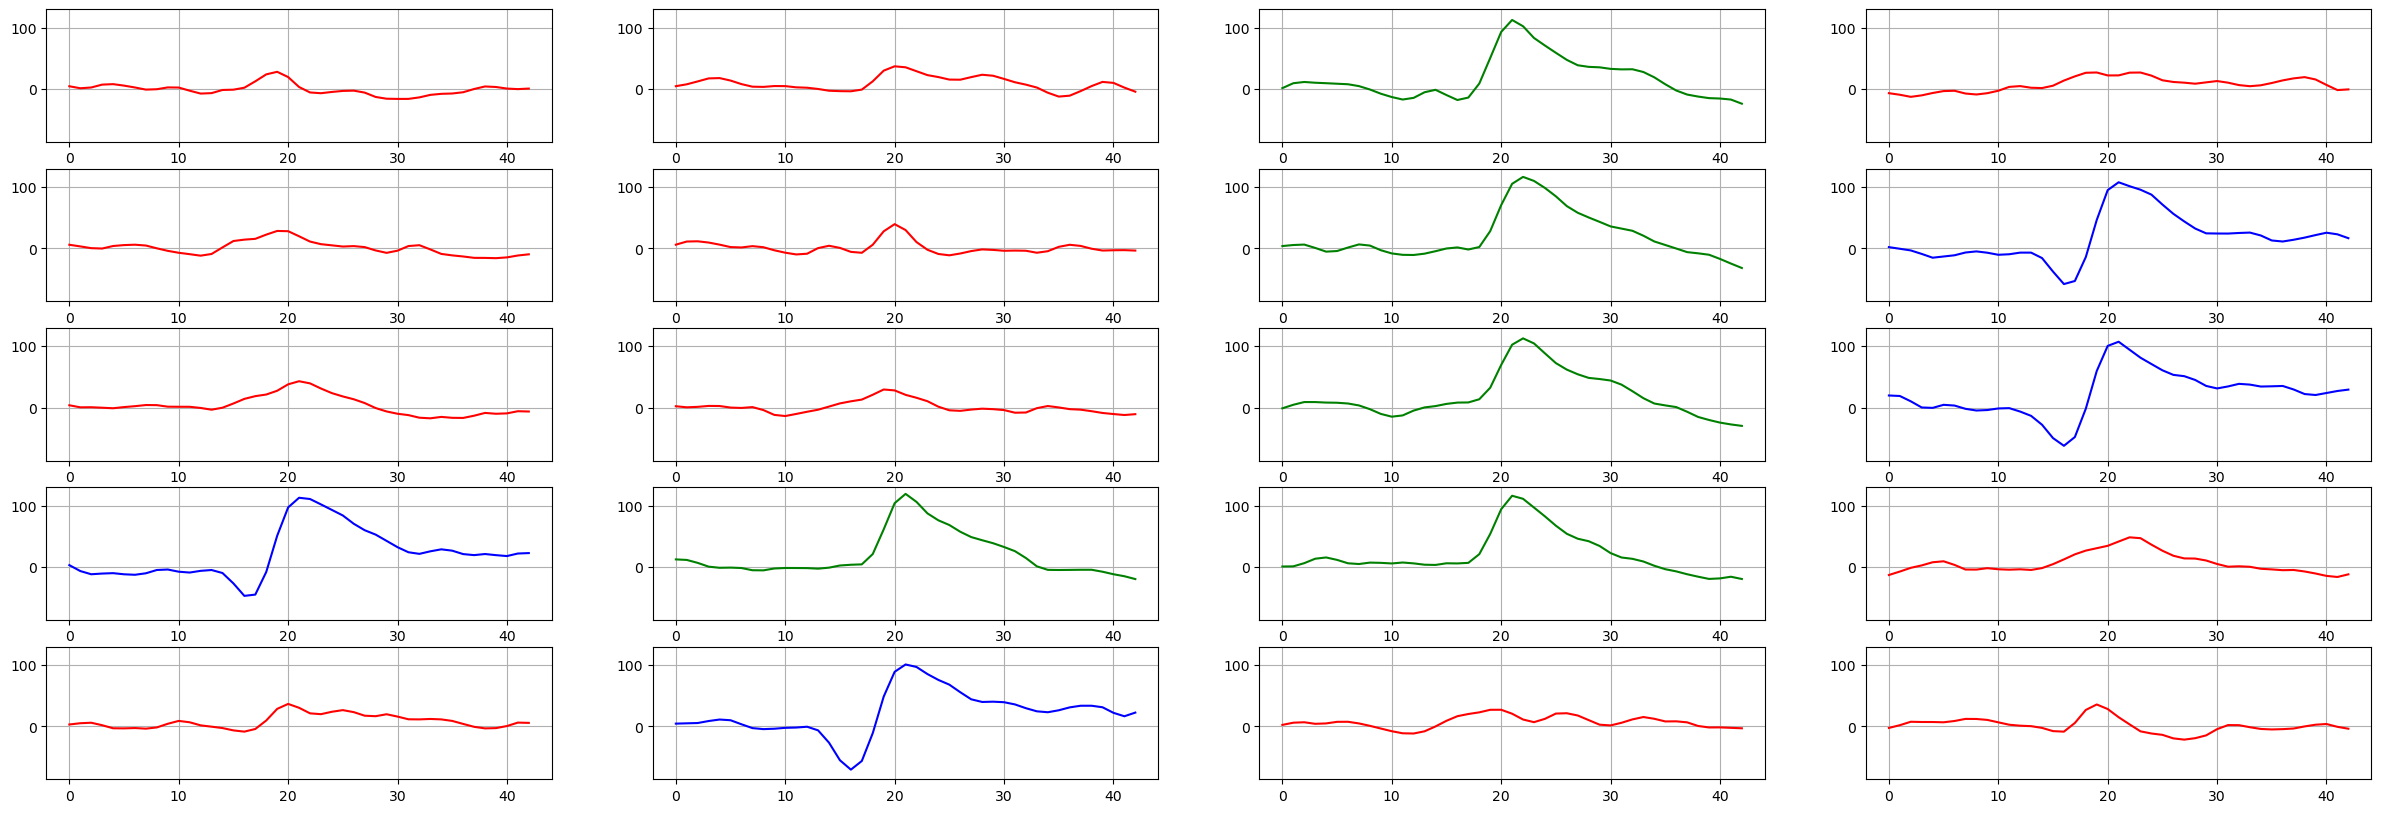

In [9]:
# apply final clustering algorithm based on optimal number of clusters
n_clusters = 3
kmeans_final = KMeans(n_init='auto', n_clusters=n_clusters)
classes = kmeans_final.fit_predict(spikes)
colors = ['r', 'g', 'b', 'orange']

# plot first 20 spikes in different colors to see if clustering worked
plt.figure(figsize=(30,10))
for i, spike in enumerate(spikes[:20]):
    plt.subplot(5, 4, i+1)
    plt.grid()
    plt.ylim(ymin, ymax)
    plt.plot(spike, c=colors[classes[i]])
plt.show()

# of spikes: 2644


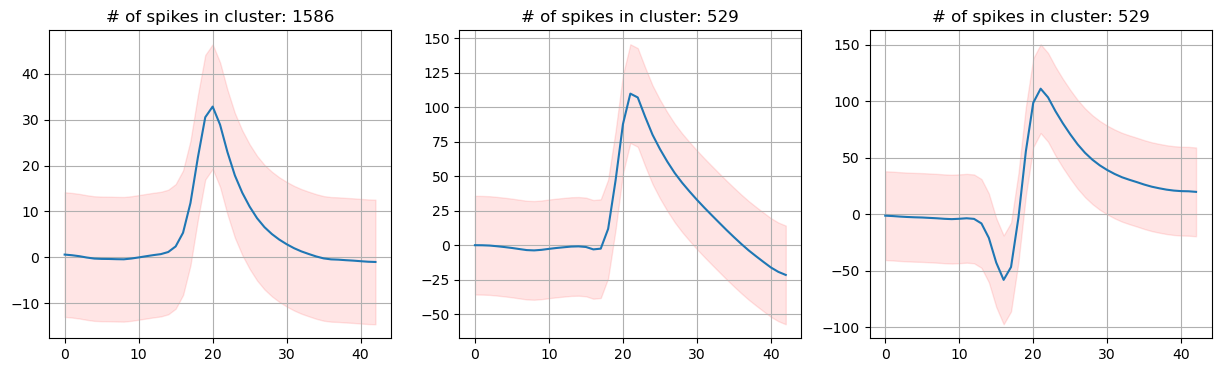

In [10]:
plt.figure(figsize=(5*n_clusters, 4))

print('# of spikes:', number_of_spikes)

# compute mean & std deviation of each spike class & plot them
for i in range(n_clusters):
    x = np.arange(0, 43, 1)
    classIndices = np.where(classes == i)[0]
    
    meanSpike = np.mean(np.array(spikes)[classIndices], axis=0)
    deviation = np.std(np.array(spikes)[classIndices])
    
    plt.subplot(1, n_clusters, i+1)
    plt.title(f'# of spikes in cluster: {len(classIndices)}')
    plt.plot(meanSpike)
    plt.fill_between(x, meanSpike - deviation, meanSpike + deviation, alpha=0.1, color='r')
    plt.grid()
plt.show()